In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import MultiHeadAttention
import datetime

log_dir = os.path.join('logs', 'fit', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(log_dir)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


logs\fit\20240608-120130


In [3]:
PATH = os.path.join('data')
actions = np.array(os.listdir(PATH))

label_map = {label: num for num, label in enumerate(actions)}

landmarks, labels = [], []

for action in actions:
    action_path = os.path.join(PATH, action)
    sequences = os.listdir(action_path)
    
    for sequence in sequences:
        temp = []
        sequence_path = os.path.join(action_path, sequence)
        
        frames = sorted(os.listdir(sequence_path)) 
        
        for frame in frames:
            npy_path = os.path.join(sequence_path, frame)
            if os.path.isfile(npy_path):
                npy = np.load(npy_path)
                temp.append(npy)
        
        if temp:
            landmarks.append(temp)
            labels.append(label_map[action])

X, Y = np.array(landmarks), to_categorical(labels).astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=34, stratify=Y)


In [10]:
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [13]:
def create_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Dense(128)(inputs)

    encoder_block1 = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=128)
    encoder_block2 = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=128)
    x = encoder_block1(x, training=True)
    x = encoder_block2(x, training=True)

    x = GlobalAveragePooling1D()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (30, 126) 
num_classes = actions.shape[0]

model = create_transformer_model(input_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(X_train, Y_train, epochs=200, callbacks=[tensorboard_callback], validation_data=(X_test, Y_test))

model.save('my_transformer_model.keras')

predictions = np.argmax(model.predict(X_test), axis=1)
test_labels = np.argmax(Y_test, axis=1)
accuracy = metrics.accuracy_score(test_labels, predictions)

print(f"Accuracy: {accuracy}")

Epoch 1/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - categorical_accuracy: 0.0842 - loss: 3.3044 - val_categorical_accuracy: 0.3430 - val_loss: 1.9232
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - categorical_accuracy: 0.3770 - loss: 1.8469 - val_categorical_accuracy: 0.6623 - val_loss: 1.0684
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - categorical_accuracy: 0.6292 - loss: 1.0971 - val_categorical_accuracy: 0.8095 - val_loss: 0.5921
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - categorical_accuracy: 0.7795 - loss: 0.6544 - val_categorical_accuracy: 0.8568 - val_loss: 0.4479
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - categorical_accuracy: 0.8796 - loss: 0.3944 - val_categorical_accuracy: 0.8476 - val_loss: 0.4723
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - categorical_accuracy: 0.8642 - loss: 0.4164 - val_categorical_accuracy: 0.9054 - val_loss: 0.2792
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - categorical_accuracy: 0.8909 - lo

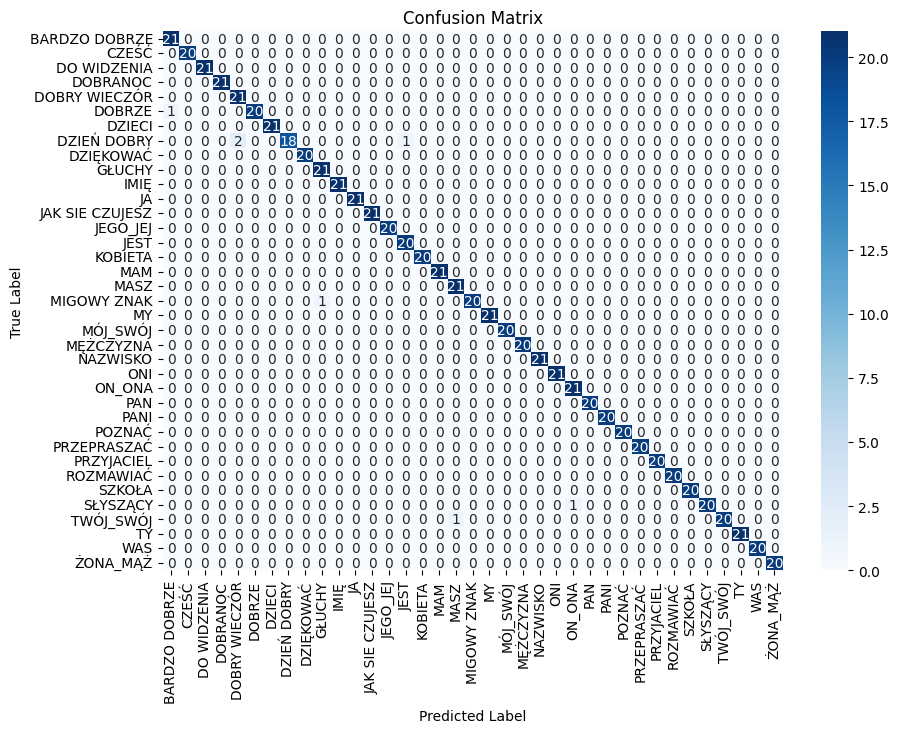

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)

labels = actions

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()